In [3]:
%matplotlib inline
import cd_diagrams as cdd
import importlib
import pandas as pd
import numpy as np
import amir_tools as at
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import functools as ft
import matplotlib
import warnings
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
from pandas import factorize

matplotlib.rc_file_defaults()
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
models = ["inception","minirocket","xresnet1d101"]

In [4]:

def make_cdd_df(exp_df):
    df_median = exp_df.reset_index()[["classifier_name","dataset_name",]]
    df_median["value"] = list(exp_df[exp_df.columns[1:-1]].mean(axis=1).values)
    df_median.columns = ["classifier_name","dataset_name","accuracy"]
    return df_median

def cd_diagram_single_model(exp_df,title="Mean F1",labels=False):
    df_median = make_cdd_df(exp_df)
    cdd.draw_cd_diagram(df_perf=df_median, title=title, labels=labels,alpha=0.05)
    
def draw_scatter_plot(exp_df):
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.set(font_scale = 3)
    data = exp_df.melt(id_vars = "classifier_name")
    data["variable"] = [at.label_shortner(x) for x in data["variable"]]

    #sns.boxplot(data=data,hue="classifier_name",x="variable",y="value",)
    ax = sns.stripplot(data=data,hue="classifier_name",x="variable",y="value",dodge=True,size=8, edgecolor='gray',)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=45)
    ax.set_xlabel("", fontsize = 25)
    ax.set_ylabel("F1 Values", fontsize = 25)
    # ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)
#     plt.legend( fontsize = 16)
#     plt.tight_layout()
    ax.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    return plt

def get_norm_experiments(model_name,dataset,clf_numbers=True,dataset_numbers=True):
    # loads the experiment results
    experiments = []
    for norm_type in ["raw","minmax"]:
        try:
            for i in range(20):
                if norm_type!="raw": 
                    df = pd.read_csv("models/scaling/csvs/%s_%s_sc-n_1.0_%s.csv"%(model_name,dataset,i))
                else:
                    df = pd.read_csv("models/normalizing/csvs/%s_%s_raw_%s.csv"%(model_name,dataset,i))
                df = df[df.columns[0:-4]]
                df = df.loc[df["index"]=="f1-score"]
                df = df.rename(columns={"index":"classifier_name"})
                df["classifier_name"] = model_name if clf_numbers==False else "%s_%s"%(model_name,lp)
                df["dataset_name"] = dataset if dataset_numbers==False else "%s_%s"%(dataset,i)
                df["norm_type"] = norm_type
                df["bootstrap"] = i
#                 df["hp"] = hp
                df.index = [i]
                experiments.append(df)
        except Exception as  e:
            print(e)
            continue
    exp_df = pd.concat(experiments)
    return exp_df




In [5]:
df = pd.concat([get_norm_experiments(x,"CPSC2018",clf_numbers=False) for x in models]).drop(columns=["dataset_name"])
df.melt(id_vars=["classifier_name","norm_type","bootstrap"])

,classifier_name,norm_type,bootstrap,variable,value
0,inception,raw,0,1st degree av block,0.819444
1,inception,raw,1,1st degree av block,0.814815
2,inception,raw,2,1st degree av block,0.829630
3,inception,raw,3,1st degree av block,0.842857
4,inception,raw,4,1st degree av block,0.827068
...,...,...,...,...,...
835,xresnet1d101,minmax,15,ventricular ectopics,0.732558
836,xresnet1d101,minmax,16,ventricular ectopics,0.713376
837,xresnet1d101,minmax,17,ventricular ectopics,0.713376
838,xresnet1d101,minmax,18,ventricular ectopics,0.630137


# complete results for factor analysis

In [17]:
dfs = []
for dataset in datasets:
    df = pd.concat([get_norm_experiments(x,dataset,clf_numbers=False) for x in models]).drop(columns=["dataset_name"])
    df = df.melt(id_vars=["classifier_name","norm_type","bootstrap"])
    df["dataset"] = dataset
    dfs.append(df)
df = pd.concat(dfs).rename(columns={"value":"F1","variable":"disease","classifier_name":"model","bootstrap":"bootstrap_num"})
# df.to_csv("csvs/model_performance_normalizing.csv",index=False)

In [52]:
df = pd.read_csv("csvs/model_performance_normalizing.csv")
# kruskal wallice for all factors, when looking at the F1 value

for c in df.columns:
    gb = df.groupby(c)
    groups = [[gb.get_group(x),x] for x in gb.groups]

    print(c,stats.kruskal(*[g[0]["F1"].values for g in groups]))

model KruskalResult(statistic=16.48543439569193, pvalue=0.00026316819700915794)
norm_type KruskalResult(statistic=13.81866054184252, pvalue=0.00020132671204536022)
bootstrap_num KruskalResult(statistic=1.2553532797540274, pvalue=0.9999999939996171)
disease KruskalResult(statistic=2581.9550696507504, pvalue=0.0)
F1 KruskalResult(statistic=3119.000000000002, pvalue=8.402838274135004e-10)
dataset KruskalResult(statistic=202.1393937243764, pvalue=1.276404613081136e-44)


In [56]:
(6.996322518088917e-05 +  1.5747293559089005e-07 + 0.000263168) /3

0.00011109623270549335

In [19]:
# for which diseases is rate a factor? 
gb = df.groupby("disease")
groups = [[gb.get_group(x),x] for x in gb.groups]
kruskal_results = {}
for data,g in groups:
    gb = data.groupby("norm_type")
    result = stats.kruskal(*[gb.get_group(x)["F1"] for x in gb.groups])
    kruskal_results[g] = result[1]

kr_df = pd.DataFrame(kruskal_results,index=[0],).T
kr_df[0] = kr_df[0]<(0.05/60)
# kr_df = kr_df.style.apply(lambda x:['font-weight: bold' if s>0 else '' for s in x])
pd.set_option('display.float_format', '{:.3e}'.format)
print(kr_df.to_latex(index=False))
kr_df

\begin{tabular}{l}
\toprule
    0 \\
\midrule
False \\
 True \\
False \\
False \\
 True \\
 True \\
 True \\
 True \\
False \\
 True \\
False \\
False \\
False \\
False \\
False \\
False \\
 True \\
False \\
False \\
False \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21427/1565680101.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(kr_df.to_latex(index=False))


,0
1st degree av block,False
abnormal QRS,True
atrial fibrillation,False
incomplete right bundle branch block,False
left anterior fascicular block,True
left axis deviation,True
left ventricular high voltage,True
left ventricular hypertrophy,True
myocardial infarction,False
myocardial ischemia,True


In [32]:
df["norm_type_factorized"],cats = factorize(df["norm_type"])
gb = df.groupby("disease")
groups = [[gb.get_group(x),x] for x in gb.groups]
corr_df = pd.DataFrame([[x[1],x[0][["norm_type_factorized","F1"]].corr(method="spearman")["F1"][0]] for x in groups])
corr_df = corr_df.set_index(0)
corr_df

,1
0,
1st degree av block,-1.001e-01
abnormal QRS,-5.115e-01
atrial fibrillation,-1.513e-01
incomplete right bundle branch block,-1.953e-01
left anterior fascicular block,-3.409e-01
left axis deviation,-4.104e-01
left ventricular high voltage,-7.051e-01
left ventricular hypertrophy,-6.442e-01
myocardial infarction,-2.204e-01


In [24]:
# MRR calculations
importlib.reload(cdd)
df = pd.read_csv("csvs/model_performance_normalizing.csv")
df["dataset_name"] = df["dataset"] + "_" + df["bootstrap_num"].astype(int).astype(str)
df["classifier_name"] = df["model"] + "_" + df["norm_type"].astype(str)
df["accuracy"] = df["F1"]
g_data = df.groupby("dataset")
disease_dict = {}
for dataset,g1 in g_data:
    g_disease = g1.groupby("disease")
    for disease,g2 in g_disease:
        df_perf=g2[["classifier_name","dataset_name","accuracy"]]
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disease_dict[disease+"-"+dataset] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05,ranking="MRR")[1]
            

the null hypothesis over the entire classifiers cannot be rejected 0.08110460591309443


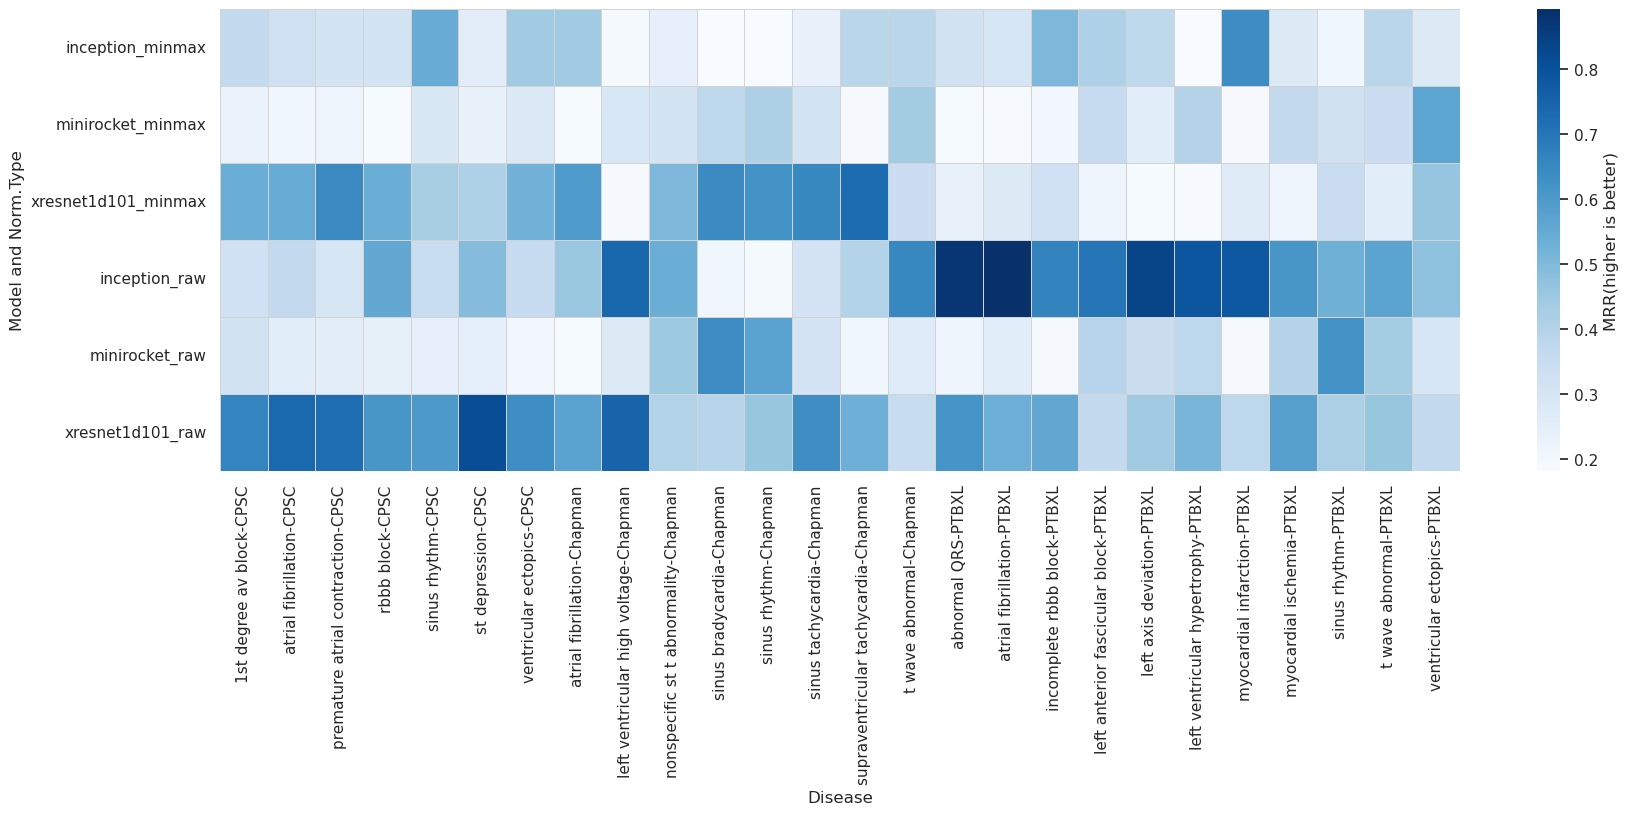

In [74]:
hm_df = pd.DataFrame(disease_dict).T
hm_df = hm_df[hm_df.columns[np.argsort([i.split("_")[-1] for i in hm_df.columns])]] # sort by scaling value

hm_df.index = hm_df.index.str.replace("ChapmanShaoxing","Chapman")
hm_df.index = hm_df.index.str.replace("CPSC2018","CPSC")
hm_df.index = hm_df.index.str.replace("right bundle branch","rbbb")

ax = sns.heatmap(hm_df.T, linewidths=.5, linecolor='lightgray',cmap=sns.color_palette("Blues", as_cmap=True))

sns.set(rc = {'figure.figsize':(20,7)})
# sns.set(font_scale = 2)

ax.set_xlabel('Disease')
ax.set_ylabel('Model and Norm.Type')
colorbar = ax.collections[0].colorbar
colorbar.ax.set_ylabel('MRR(higher is better)',)
fig = ax.get_figure()

fig.savefig('images/Per-Disease_normalizing_performance.pdf',bbox_inches='tight')

In [30]:
# per model
for m in models:
    corr_df = hm_df.T
    corr_df = corr_df[corr_df.index.str.contains(m)].reset_index().melt(id_vars=["index"]).drop(columns=["variable"]) 
    corr_df["index"] = corr_df["index"].apply(lambda x: x.split("_")[-1])
    
    print(m,corr_df.corr(method="spearman")["value"][0])

inception 1.0
minirocket 1.0
xresnet1d101 1.0


In [46]:
df["norm_type_factorized"],cats = factorize(df["norm_type"])
gb = df.groupby("model")
for x in gb.groups:
    print(x)
    print(gb.get_group(x).corr()["F1"])

inception
bootstrap_num           7.578e-04
F1                      1.000e+00
accuracy                1.000e+00
norm_type_factorized   -1.165e-01
Name: F1, dtype: float64
minirocket
bootstrap_num           9.671e-04
F1                      1.000e+00
accuracy                1.000e+00
norm_type_factorized   -1.205e-02
Name: F1, dtype: float64
xresnet1d101
bootstrap_num          -1.064e-02
F1                      1.000e+00
accuracy                1.000e+00
norm_type_factorized   -9.498e-02
Name: F1, dtype: float64


In [47]:
df.corr()

,bootstrap_num,F1,accuracy,norm_type_factorized
bootstrap_num,1.000e+00,-2.947e-03,-2.947e-03,1.047e-17
F1,-2.947e-03,1.000e+00,1.000e+00,-7.413e-02
accuracy,-2.947e-03,1.000e+00,1.000e+00,-7.413e-02
norm_type_factorized,1.047e-17,-7.413e-02,-7.413e-02,1.000e+00
